In [1]:
#IMPORTANT IMPORT
from pynq import Overlay
from pynq import allocate

import numpy as np
import time
import math
import matplotlib.pyplot as plt

In [70]:
# Sample generator
N = 8
FXP = 1024
data_real = np.array([])
data_imag = np.array([])
data_complex = np.array([])

for i in range (N):
    data_real = np.append(data_real,np.random.rand())
    data_imag = np.append(data_imag,np.random.rand())

data_complex = data_real + 1j*data_imag    


#Convert data to data fixed-point 14:10
for i in range (N):
    data_real[i] =  int(data_real[i]*FXP)
    data_imag[i] =  int(data_imag[i]*FXP)
  

In [71]:
#Sample function

def fft_sample(x):
    N = len(x)
    if N == 1:
        return [x[0]]
    X = [0] * N
    even = fft_sample(x[:N:2])
    odd = fft_sample(x[1:N:2])
    for k in range(N // 2):
        w = math.e ** (-2j * math.pi * k / N)
        X[k] = even[k] + w * odd[k]
        X[k + N // 2] = even[k] - w * odd[k]
    return X

In [72]:
## Overlay for FFT Version 1 (with one butterfly)
fft_ov = Overlay("fft_seq_wrapper.xsa")
fft_seq = fft_ov.fft_seq_ip_0.mmio

In [73]:
# FFT Implementation on FPGA (with one butterfly)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_sequential(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_seq.write(start_offset,1)    
    
    for i in range(N_size):
        fft_seq.write(data_en_offset,0)
        fft_seq.write(in_R_offset,int(in_r[i]))
        fft_seq.write(in_I_offset,int(in_i[i]))
        fft_seq.write(data_en_offset,1)
        
    fft_seq.write(data_en_offset,0) 
    while (fft_seq.read(ready_offset) == 0):
        pass
     
    for i in range(N_size):
        fft_seq.write(data_en_offset,1)
        out_r = np.append(out_r, fft_seq.read(out_R_offset))
        out_i = np.append(out_i, fft_seq.read(out_I_offset))
        fft_seq.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_seq.write(start_offset,0)
    return (out_r, out_i)

RMSE: 0.002570921489581


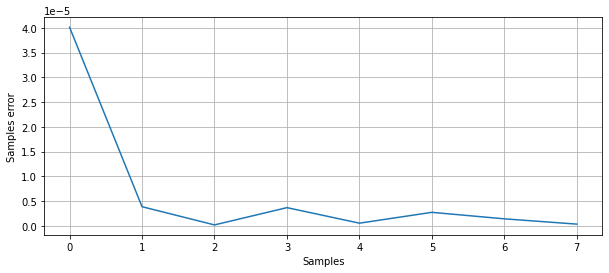

In [74]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (with one butterfly)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (with one butterfly)
X_fpga_r_seq , X_fpga_i_seq = fft_sequential(data_real, data_imag)

X_fpga_complex_seq = np.array([])
X_fpga_complex_seq = X_fpga_r_seq + 1j*X_fpga_i_seq
X_fpga_complex_seq = X_fpga_complex_seq/FXP

# Error between sample implementation and fpga implementation
X_err_seq = np.abs(X_fpga_complex_seq - X_sample)**2
# RMSE
X_RMSE_seq = np.sqrt(np.mean(X_err_seq))
print('RMSE:', np.round(X_RMSE_seq, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_seq)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [75]:
## Overlay for FFT Version 2 (with parallel butterflies)
fft_ov = Overlay("fft_parallel_wrapper.xsa")
fft_parallel = fft_ov.fft_parallel_ip_0.mmio

In [76]:
# FFT Implementation on FPGA (with parallel butterflies)

N_size = 8
start_offset = 8
data_en_offset = 12
ready_offset = 16
in_R_offset = 20
in_I_offset = 24
out_R_offset = 28
out_I_offset = 32


def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_parall(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    
    fft_parallel.write(start_offset,1)    
    
    for i in range(N_size):
        fft_parallel.write(data_en_offset,0)
        fft_parallel.write(in_R_offset,int(in_r[i]))
        fft_parallel.write(in_I_offset,int(in_i[i]))
        fft_parallel.write(data_en_offset,1)
    
    fft_parallel.write(data_en_offset,0)    
    while (fft_parallel.read(ready_offset) == 0):
        pass
    
    for i in range(N_size):
        fft_parallel.write(data_en_offset,1)
        out_r = np.append(out_r, fft_parallel.read(out_R_offset))
        out_i = np.append(out_i, fft_parallel.read(out_I_offset))
        fft_parallel.write(data_en_offset,0)
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    fft_parallel.write(start_offset,0)
    return (out_r, out_i)

RMSE: 0.002570921489581


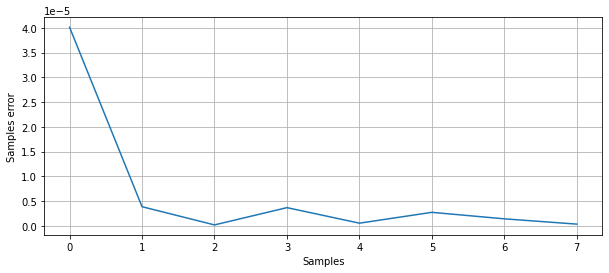

In [79]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (with parallel butterflies)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (with parallel butterflies)
X_fpga_r_parallel , X_fpga_i_parallel = fft_parall(data_real, data_imag)

X_fpga_complex_parallel = np.array([])
X_fpga_complex_parallel = X_fpga_r_parallel + 1j*X_fpga_i_parallel
X_fpga_complex_parallel = X_fpga_complex_parallel/FXP

# Error between sample implementation and fpga implementation
X_err_parallel = np.abs(X_fpga_complex_parallel - X_sample)**2
# RMSE
X_RMSE_parallel = np.sqrt(np.mean(X_err_parallel))
print('RMSE:', np.round(X_RMSE_parallel, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_parallel)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [83]:
## Overlay for FFT Version 3 (divided into stages)
fft_ov = Overlay("fft_divided_stage_wrapper.xsa")
fft_stages = fft_ov.fft_pipe_N8_0.mmio

In [84]:
# FFT Implementation on FPGA (divided into stages)
N_size = 8
start_offset = 0
ready_offset = 132
in_buffer_offset = [x*4 for x in range(1,17)]
out_buffer_offset = [x*4 for x in range(17,33)]

def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_divided_into_stages(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    fft_stages.write(start_offset,0)
    for i in range(N_size):
        fft_stages.write(in_buffer_offset[i],int(in_r[i]))
        fft_stages.write(in_buffer_offset[i+N_size],int(in_i[i]))
    
    fft_stages.write(start_offset,1)
    while (fft_stages.read(ready_offset) == 0):
        pass 
    for i in range(N_size):
        out_r = np.append(out_r, fft_stages.read(out_buffer_offset[i]))
        out_i = np.append(out_i, fft_stages.read(out_buffer_offset[i+N_size]))
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    
    return (out_r, out_i)
    

RMSE: 0.002570921489581


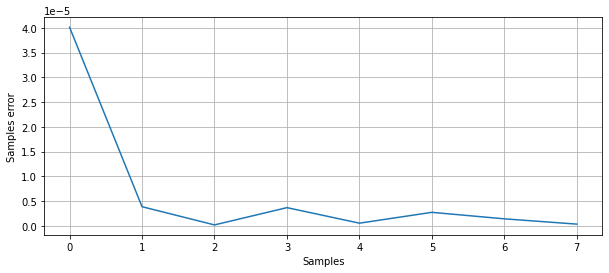

In [85]:
#Implementation comparison -> Sample function vs FFT Implementation on FPGA (divided into stages)

#Compute FFT using sample function
X_sample = fft_sample(data_complex)

#Compute FFT using FFT Implementation on FPGA (divided into stages)
X_fpga_r_stages , X_fpga_i_stages = fft_divided_into_stages(data_real, data_imag)

X_fpga_complex_stages = np.array([])
X_fpga_complex_stages = X_fpga_r_stages + 1j*X_fpga_i_stages
X_fpga_complex_stages = X_fpga_complex_stages/FXP

# Error between sample implementation and fpga implementation
X_err_stages = np.abs(X_fpga_complex_stages - X_sample)**2
# RMSE
X_RMSE_stages = np.sqrt(np.mean(X_err_stages))
print('RMSE:', np.round(X_RMSE_stages, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err_pipeN8)
ax.set_ylabel('Samples error')
ax.set_xlabel('Samples')
plt.grid()
plt.show()

In [86]:
#Implementation comparison
print('RMSE FFT Version 1 (with one butterfly):', np.round(X_RMSE_seq, 15))
print('RMSE FFT Version 2 (with parallel butterflies):', np.round(X_RMSE_parallel, 15))
print('RMSE FFT Version 3 (divided into stages):', np.round(X_RMSE_stages, 15))

RMSE FFT Version 1 (with one butterfly): 0.002570921489581
RMSE FFT Version 2 (with parallel butterflies): 0.002570921489581
RMSE FFT Version 3 (divided into stages): 0.002570921489581


In [187]:
# Sample generator for pipeline version FFT
N_pipeline = 8
N_packs = 1
FXP_pipeline = 64
data_real_pipeline = np.array([],dtype=np.int16)
data_imag_pipeline = np.array([],dtype=np.int16)
data_complex_pipeline = np.array([])

for i in range (N_packs*N_pipeline):
    data_real_pipeline = np.append(data_real_pipeline,np.random.rand())
    data_imag_pipeline = np.append(data_imag_pipeline,np.random.rand())

data_complex_pipeline = data_real_pipeline + 1j*data_imag_pipeline
#Convert data to data fixed-point 10:6
for i in range (N_packs*N_pipeline):
    data_real_pipeline[i] =  int(data_real_pipeline[i]*FXP_pipeline)
    data_imag_pipeline[i] =  int(data_imag_pipeline[i]*FXP_pipeline)

In [188]:
fft_ov = Overlay("fft.xsa")
fft_pipe = fft_ov.axi_dma_0

In [189]:
in_buffer = allocate(shape=(N_packs*N_pipeline,), dtype=np.uint32)
out_buffer = allocate(shape=(N_packs*N_pipeline,), dtype=np.uint32)
array1_uint32 = data_real_pipeline.astype(np.uint32)
array2_uint32 = data_imag_pipeline.astype(np.uint32)

for i in range(N_packs*N_pipeline):
    in_buffer[i] =(array2_uint32[i] << 16) | array1_uint32[i]
print(in_buffer)

[3997750 1572903 1048604 2883590 3932171 1441793 3866668 3801146]


In [190]:
fft_pipe.sendchannel.transfer(in_buffer)
fft_pipe.recvchannel.transfer(out_buffer)

RMSE for data pack [ 1 ] : 0.034774789453433


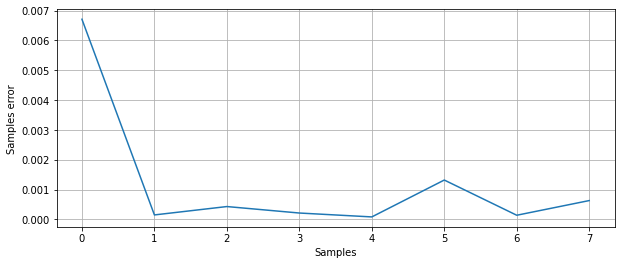

In [191]:
array1_out = np.array([],dtype=np.int16)
array2_out = np.array([],dtype=np.int16)
X_sample_pipeline = []
X_fpga_pipeline = []
X_err_pipeline = []
X_RMSE_pipeline = []

for i in range(N_packs*N_pipeline):
    array1_out = np.append(array1_out, (out_buffer[i] & 0x0000ffff).astype(np.int16))
    array2_out = np.append(array2_out, (out_buffer[i] >> 16).astype(np.int16))
    
array1_out =array1_out/FXP_pipeline
array2_out =array2_out/FXP_pipeline

X_pipe = array1_out + 1j*array2_out
for i in range(N_packs):
    X_fpga_pipeline.append(X_pipe[N_pipeline*i:N_pipeline*(i+1)])
for i in range(N_packs):
    X_sample_pipeline.append(fft_sample(data_complex_pipeline[N_pipeline*i:N_pipeline*(i+1)]))

for i in range(N_packs):    
    X_err_pipeline.append(np.abs(X_fpga_pipeline[i] - X_sample_pipeline[i])**2)
    X_RMSE_pipeline.append(np.sqrt(np.mean(X_err_pipeline)))

for i in range(N_packs):
    print('RMSE for data pack [',i+1,'] :', np.round(X_RMSE_pipeline[i], 15))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.plot(X_err_pipeline[i])
    ax.set_ylabel('Samples error')
    ax.set_xlabel('Samples')
    plt.grid()
    plt.show()

In [192]:
del in_buffer
del out_buffer